# Objetivo: Descobrir objetos em imagens por meio de API Azure

## Import Library

In [1]:
# bibliotecas de visão computacional
from PIL import Image
from io import BytesIO

# bibliotecas de manipulação
import pandas as pd
import numpy as np

# bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

# bibliotecas de machine learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# bibliotecas de balanceamento de dados
from imblearn.under_sampling import RandomUnderSampler

# bibliotecas de preprocessamento
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer

# outras bibliotecas
import datetime
import os, sys
import warnings
import requests

In [2]:
# opções para o pandas
pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.options.mode.use_inf_as_na=True
pd.options.display.max_colwidth=None

# opções para visualizações
%matplotlib inline

# opções para Jupyter notebook
warnings.filterwarnings('ignore')

## Parâmetros da API

In [99]:
# passando parâmetros para caputurar itens relevantes reconhecidos na imagem
headers = {'Ocp-Apim-Subscription-Key': subscription_key,
           'Content-Type': 'application/octet-stream'}
params = {'visualFeatures': 'Categories,Description,Color', 'details': 'Celebrities,Landmarks', 'language': 'pt'}

## Funções do Projeto

In [197]:
# Função para retornar dataframe Pandas com itens identificados na imagem
def AzureAPI(path, progress=True):
    imagem=[]
    cor_frente=[]
    cor_fundo=[]
    cor_dominante=[]
    tags=[]
    texto=[]
    landmarks=[]
    landmarks_return=[]

    for i in imgs:
        
        if progress:
            print('Analisando imagem', i)

        # abrindo imagem
        image_data=open(i, "rb").read()
    
        try:
            # Chamando serviço do Azure
            response = requests.post(
                analyze_url, headers=headers, params=params, data=image_data)
            response.raise_for_status()
    
            # a propriedade "description" contém os itens mais importantes captados da imagem
            analysis = response.json()
    
            # guardando análise da imagem
            imagem.append(i)
            cor_frente.append(analysis['color']['dominantColorForeground'])
            cor_fundo.append(analysis['color']['dominantColorBackground'])
            cor_dominante.append(analysis['color']['dominantColors'])
            tags.append(analysis['description']['tags'])
            texto.append(analysis['description']['captions'][0]['text'])
            for i in analysis['categories']:
                if 'detail' in i:
                    landmarks_return=analysis['categories'][1]['detail']['landmarks']
            landmarks.append(landmarks_return)
            retorno.append(analysis)

        except:
            print('Erro ao capturar imagem ' + i)
            break
    
    #retornando dataframe pandas
    return pd.DataFrame([imagem, cor_frente, cor_fundo, cor_dominante, tags, texto, landmarks],
                        index=['Imagem', 'Cor Frente', 'Cor Fundo', 'Cor dominante', 'Tags', 'Texto', 'Referência']).T

# Função para visualizar imagens
def visualizar(df, index):
    image_data=open(df.iloc[index]['Imagem'], "rb").read()
    
    # Display the image and overlay it with the caption.
    image = Image.open(BytesIO(image_data))
    plt.imshow(image)
    plt.axis("off")
    _ = plt.title(df.iloc[index]['Imagem'], size="x-large", y=-0.1)
    plt.show()
    print('TEXTO........: ',  df.iloc[index]['Texto'])
    print('TAGS.........: ',  df.iloc[index]['Tags'])
    print('COR DOMINANTE: ',  df.iloc[index]['Cor dominante'])
    print('COR FRENTE...: ',  df.iloc[index]['Cor Frente'])
    print('COR FUNDO....: ',  df.iloc[index]['Cor Fundo'])
    print('REFERÊNCIA...: ',  df.iloc[index]['Referência'])

## Identificando Chave de Subscrição e Endpoint

In [3]:
# checando se a chave de subscrição de visão computacional e endpoint possuem variável de ambiente criada
# se não tiver, é necessário obter ambos em "gerenciamento de recursos > Chaves e Ponto de extremidade", cadastrá-los
# como variáveis de ambiente, e reiniciar o Jupyter, caso não queira passá-los diretamente, por segurança, para 
# variáveis a serem usadas no código

if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
    subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
else:
    print("\nGrave COMPUTER_VISION_SUBSCRIPTION_KEY em uma variável de ambiente.\n**Reinicie o Jupyter para fazer efeito.**")
    sys.exit()

if 'COMPUTER_VISION_ENDPOINT' in os.environ:
    endpoint = os.environ['COMPUTER_VISION_ENDPOINT']
else:
    print("\nGrave COMPUTER_VISION_ENDPOINT em uma variável de ambiente.\n**Reinicie o Jupyter para fazer efeito.**")
    sys.exit()
    
analyze_url = endpoint + "vision/v3.0/analyze"

## Obtendo características

In [163]:
# setando path de localização das imagens
path_imagens='../img/'

# capturando lista de imagens do diretório
imgs=[path_imagens+i for i in os.listdir(path_imagens) if i[-3:] in ['pgn', 'jpg']]

# obtendo dataframe pandas com características das imagens
df=AzureAPI(imgs)

Analisando imagem ../img/foto1.jpg
Analisando imagem ../img/foto2.jpg
Analisando imagem ../img/foto3.jpg
Analisando imagem ../img/foto4.jpg
Analisando imagem ../img/foto5.jpg
Analisando imagem ../img/foto6.jpg
Analisando imagem ../img/foto7.jpg


In [164]:
df

,Imagem,Cor Frente,Cor Fundo,Cor dominante,Tags,Texto,Referência
0,../img/foto1.jpg,White,Brown,"[Brown, White, Black]","[carro, ao ar livre, grama, estacionado, caminhão, rua, estacionamento, neve, velho, terra, medidor, campo, lado, porta-malas, dirigindo, andando de, hidrante, em pé, fogo]",carro parado na terra,[]
1,../img/foto2.jpg,White,Grey,"[White, Grey, Pink]","[carro, pessoa, ao ar livre, estrada, mulher, andando de, jovem, homem, frente, menina, segurando, cama, em pé, bagagem, tráfego, placa, rua, pessoas]",mulher na frente de um carro,[]
2,../img/foto3.jpg,Grey,Brown,[],"[montanha, ao ar livre, carro, deserto, moto, terra, fundo, caminhão, estacionado, pequeno, velho, muito, marrom, dirigindo, homem, seco, andando de, campo, surfando, estacionamento]",carro em estrada de terra com montanha ao fundo,[]
3,../img/foto4.jpg,Grey,Grey,[Grey],"[estrada, ao ar livre, carro, caminhão, cidade, rua, dirigindo, frente, andando de, pequeno, estacionamento, puxando, estacionado, viajando, moto, grande, muito, homem, alto, ônibus, fogo]",carro de corrida na rua,[]
4,../img/foto5.jpg,Grey,Grey,[Grey],"[ao ar livre, natureza, praia, água, oceano, montanha, areia, homem, arenoso, andando, em pé, barco, nublado, pessoas, surfando, voando, segurando, grupo, pipa, jogando, frisbee]",pessoas andando na areia da praia,[]
5,../img/foto6.jpg,White,White,"[White, Teal]","[pessoa, no interior, homem, segurando, mulher, mesa, olhando, pessoas, telefone, laptop, celular, casal, comida, usando, falando, vidro, computador, óculos, vinho, em pé, remoto, camisa, vídeo, jogando, grupo, jogo]",homem segurando mulher no colo,[]
6,../img/foto7.jpg,White,White,"[White, Brown]","[pessoa, ao ar livre, bicicleta, homem, mulher, placa, andando de, mesa, segurando, pessoas, em pé, telefone]",homem ao lado de uma bicicleta,[]


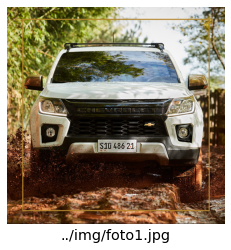

TEXTO........:  carro parado na terra
TAGS.........:  ['carro', 'ao ar livre', 'grama', 'estacionado', 'caminhão', 'rua', 'estacionamento', 'neve', 'velho', 'terra', 'medidor', 'campo', 'lado', 'porta-malas', 'dirigindo', 'andando de', 'hidrante', 'em pé', 'fogo']
COR DOMINANTE:  ['Brown', 'White', 'Black']
COR FRENTE...:  White
COR FUNDO....:  Brown
REFERÊNCIA...:  []


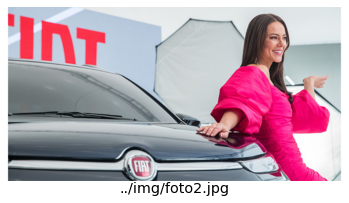

TEXTO........:  mulher na frente de um carro
TAGS.........:  ['carro', 'pessoa', 'ao ar livre', 'estrada', 'mulher', 'andando de', 'jovem', 'homem', 'frente', 'menina', 'segurando', 'cama', 'em pé', 'bagagem', 'tráfego', 'placa', 'rua', 'pessoas']
COR DOMINANTE:  ['White', 'Grey', 'Pink']
COR FRENTE...:  White
COR FUNDO....:  Grey
REFERÊNCIA...:  []


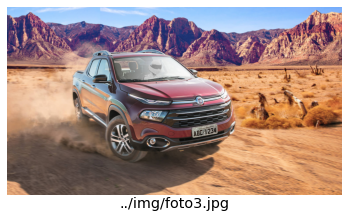

TEXTO........:  carro em estrada de terra com montanha ao fundo
TAGS.........:  ['montanha', 'ao ar livre', 'carro', 'deserto', 'moto', 'terra', 'fundo', 'caminhão', 'estacionado', 'pequeno', 'velho', 'muito', 'marrom', 'dirigindo', 'homem', 'seco', 'andando de', 'campo', 'surfando', 'estacionamento']
COR DOMINANTE:  []
COR FRENTE...:  Grey
COR FUNDO....:  Brown
REFERÊNCIA...:  []


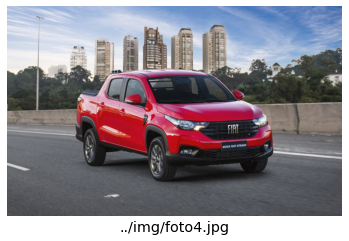

TEXTO........:  carro de corrida na rua
TAGS.........:  ['estrada', 'ao ar livre', 'carro', 'caminhão', 'cidade', 'rua', 'dirigindo', 'frente', 'andando de', 'pequeno', 'estacionamento', 'puxando', 'estacionado', 'viajando', 'moto', 'grande', 'muito', 'homem', 'alto', 'ônibus', 'fogo']
COR DOMINANTE:  ['Grey']
COR FRENTE...:  Grey
COR FUNDO....:  Grey
REFERÊNCIA...:  []


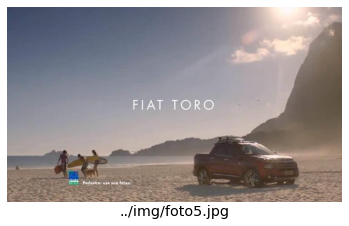

TEXTO........:  pessoas andando na areia da praia
TAGS.........:  ['ao ar livre', 'natureza', 'praia', 'água', 'oceano', 'montanha', 'areia', 'homem', 'arenoso', 'andando', 'em pé', 'barco', 'nublado', 'pessoas', 'surfando', 'voando', 'segurando', 'grupo', 'pipa', 'jogando', 'frisbee']
COR DOMINANTE:  ['Grey']
COR FRENTE...:  Grey
COR FUNDO....:  Grey
REFERÊNCIA...:  []


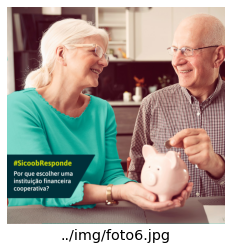

TEXTO........:  homem segurando mulher no colo
TAGS.........:  ['pessoa', 'no interior', 'homem', 'segurando', 'mulher', 'mesa', 'olhando', 'pessoas', 'telefone', 'laptop', 'celular', 'casal', 'comida', 'usando', 'falando', 'vidro', 'computador', 'óculos', 'vinho', 'em pé', 'remoto', 'camisa', 'vídeo', 'jogando', 'grupo', 'jogo']
COR DOMINANTE:  ['White', 'Teal']
COR FRENTE...:  White
COR FUNDO....:  White
REFERÊNCIA...:  []


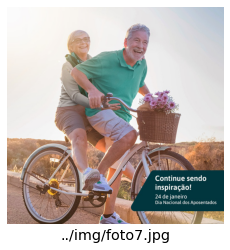

TEXTO........:  homem ao lado de uma bicicleta
TAGS.........:  ['pessoa', 'ao ar livre', 'bicicleta', 'homem', 'mulher', 'placa', 'andando de', 'mesa', 'segurando', 'pessoas', 'em pé', 'telefone']
COR DOMINANTE:  ['White', 'Brown']
COR FRENTE...:  White
COR FUNDO....:  White
REFERÊNCIA...:  []


In [202]:
for i in range(df.shape[0]):
    visualizar(df, i)